In [2]:
#seach for organic tweets and save them in one list
from collections import Counter
import csv
tweets=[]
positive_tweets = 0
negative_tweets = 0
other_tweets = 0

with open( 'D:\AllSamplesPositiveandNeutral.csv', "rb") as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        if row['sent']== '1':
            positive_tweets += 1
        elif row['sent']== '-1':
            negative_tweets += 1
        else:
            other_tweets += 1
            
        tweets.append(row)
        
print 'We have', len(tweets), 'sampled tweets'
print positive_tweets, 'are positive'
print negative_tweets, 'are negative'
print other_tweets, 'are nothing'

We have 2000 sampled tweets
676 are positive
0 are negative
1324 are nothing


In [3]:
# Create label vector (y) that show the class labels of each tweet
#print the count of each class label
from collections import Counter
import numpy as np
y = np.array([int(t['sent']) for t in tweets])#savind labels of the class in y
print 'label counts=', Counter(y)


label counts= Counter({0: 1324, 1: 676})


Populating the interactive namespace from numpy and matplotlib


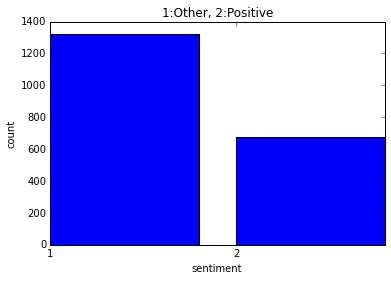

In [4]:
%pylab inline
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt

counts = Counter(y).values()
vals = [1,2]

plt.bar(vals, counts)
plt.xticks(vals)
plt.xlabel('sentiment')
plt.ylabel('count')
plt.title('1:Other, 2:Positive')
plt.show()

In [5]:
#lower=True	punct=True	url=False	mention=True
import re

def tokenize(string, lowercase, keep_punctuation, collapse_urls, collapse_mentions):
    if not string:
        return []
    if lowercase:
        string = string.lower()
    tokens = []
    if collapse_urls:
        string = re.sub('http\S+', 'THIS_IS_A_URL', string)
    if collapse_mentions:
        string = re.sub('@\S+', 'THIS_IS_A_MENTION', string)
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
    return tokens

def tweet2tokens(tweet, lowercase=True,keep_punctuation=True,collapse_urls=True, collapse_mentions=True):
    tokens = tokenize(tweet['text'], lowercase, keep_punctuation,collapse_urls, collapse_mentions)
    return tokens


In [6]:
# Let's tokenize all tweets.
tokens_list = [tweet2tokens(t, lowercase=True,keep_punctuation=False,collapse_urls=True, collapse_mentions=True) for t in tweets]

In [7]:
tokens_list[1]

['THIS_IS_A_MENTION',
 'anything',
 'that',
 'attracts',
 'people',
 'away',
 'from',
 'tobacco',
 'cigarettes',
 'is',
 'a',
 'good',
 'thing',
 'inc',
 'ecig',
 'flavours',
 'euecigban']

In [8]:
def tokenize1(string, lowercase=True, keep_punctuation=False,collapse_urls=True, collapse_mentions=True):
    if not string:
        return []
    if lowercase:
        string = string.lower()
    tokens = []
    if collapse_urls:
        string = re.sub('http\S+', 'THIS_IS_A_URL', string)
    if collapse_mentions:
        string = re.sub('@\S+', 'THIS_IS_A_MENTION', string)
    if keep_punctuation:
        tokens = string.split()
    else:
        tokens = re.sub('\W+', ' ', string).split()
    return tokens

def tweet2tokens(tweet, lowercase=True,keep_punctuation=True,collapse_urls=True, collapse_mentions=True):
    tokens = tokenize(tweet['text'], lowercase, keep_punctuation, collapse_urls, collapse_mentions)
    return tokens


In [9]:
# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)#lowercase, url's, mentions
X = vectorizer.fit_transform(t['text'] for t in tweets)
print 'vectorized %d tweet. found %d terms.' % (X.shape[0], X.shape[1])

vectorized 2000 tweet. found 1996 terms.


In [10]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv(X, y, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(), X, y, cv=cv))
  
print do_cv(X, y)

0.8105


In [11]:
# Fit a LogisticRegression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model.predict(X)
print 'accuracy on training data=%.3f' % accuracy(y, predicted)


# 5 Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []
print 'Fitting in the labeled data:'
#print 'Train set:',X[train_ind].shape[0], '\f Test set:', X[test_ind].shape[0]
for train_ind, test_ind in cv:
    model.fit(X[train_ind], y[train_ind])
    
    predictions = model.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

accuracy on training data=0.864
Fitting in the labeled data:
Average 5-fold cross validation accuracy=0.8105 (std=0.03)


In [12]:
#confusion matrix for model_mod (best parameters - actually same default)
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred = model.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.14


Predicted,0,1
Expected,,
0,1267,57
1,228,448


In [13]:
#precision, recall and F1 measures for both classes
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = model.predict(X)
print '1',precision_recall_fscore_support(y_true, y_pred)

1 (array([ 0.84749164,  0.88712871]), array([ 0.95694864,  0.66272189]), array([ 0.89890032,  0.75867909]), array([1324,  676], dtype=int64))


Parameter: l1 Accuracy: 0.797
Parameter: l2 Accuracy: 0.8105


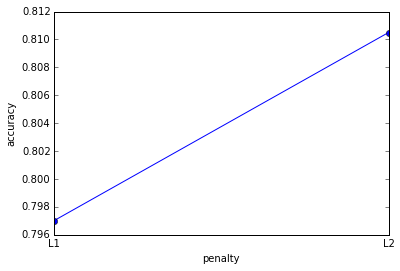

In [14]:
# changing parameters of classifier 
#penalty=l1 and l2
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv_penalty(X, y, penalty, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(penalty=penalty), X, y, cv=cv))
  

import matplotlib.pyplot as plt

def compare_ngrams(tweets, y):
    accuracies = []
    clf_param = ['l1','l2']
    i=0
    for pr in clf_param:
        accuracies.append(do_cv_penalty(X,y,penalty=pr))
        print 'Parameter:', pr, 'Accuracy:', accuracies[i]
        i+=1
    plt.figure()
    plt.plot(accuracies, 'bo-')
    #plt.xticks(range(len(pr)), pr)
    plt.xticks(range(2), ['L1','L2'] )
               
    plt.xlabel('penalty')
    plt.ylabel('accuracy')
    plt.show()
        
compare_ngrams(tweets, y)



C parameter: 0.01 Accuracy: 0.662
C parameter: 0.5 Accuracy: 0.7955
C parameter: 0.6 Accuracy: 0.8035
C parameter: 0.7 Accuracy: 0.8045
C parameter: 0.8 Accuracy: 0.8055
C parameter: 0.9 Accuracy: 0.808
C parameter: 1 Accuracy: 0.8105
C parameter: 2.6 Accuracy: 0.818
C parameter: 5 Accuracy: 0.8125
C parameter: 10 Accuracy: 0.8035
C parameter: 30 Accuracy: 0.8015
C parameter: 50 Accuracy: 0.7965
C parameter: 70 Accuracy: 0.7945
C parameter: 100 Accuracy: 0.7905


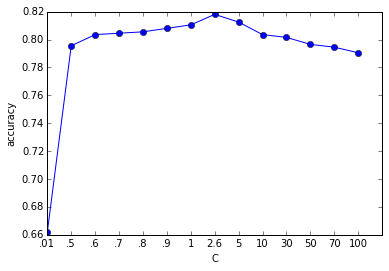

In [15]:
# changing parameters of classifier 
#C
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression

def do_cv_C(X, y, c, nfolds=10):
    cv = KFold(len(y), nfolds)
    return np.mean(cross_val_score(LogisticRegression(C=c), X, y, cv=cv))
  

import matplotlib.pyplot as plt

def compare_c(tweets, y):
    accuracies = []
    c_param = [.01, .5,.6,.7,.8,.9,1,2.6, 5, 10, 30,50,70,100]
    i=0
    for c in c_param:
        accuracies.append(do_cv_C(X,y,c))
        print 'C parameter:',c,'Accuracy:',accuracies[i]
        i+=1
    plt.figure()
    plt.plot(accuracies, 'bo-')
    #plt.xticks(range(len(c)), c)
    #plt.xticks(c_param)
    plt.xticks(range(14), ['.01', '.5','.6','.7','.8','.9','1','2.6' ,'5', '10', '30','50','70','100'])
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.show()   
compare_c(tweets, y)
 

In [17]:
# Fit a LogisticRegression model modified parameters (actually same parameters)
from sklearn.linear_model import LogisticRegression
model_mod = LogisticRegression(penalty='l2', C=2.6)
model_mod.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model_mod.predict(X)
print 'accuracy on training data=%.4f' % accuracy(y, predicted)


# 5 Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []
for train_ind, test_ind in cv:
    model_mod.fit(X[train_ind], y[train_ind])
    
    predictions = model_mod.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

accuracy on training data=0.9055
Average 5-fold cross validation accuracy=0.8180 (std=0.03)


In [69]:
# Do GridSearch on all parameters.
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint

pipeline = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)),
    ('clf', LogisticRegression()),
])

parameters = {
    'clf__penalty': ('l1','l2'),
    'clf__C': (.01, .5,.6,.7,.8,.9,1,1.5,2,2.5,2.6,3, 5, 10, 30,50,70, 100),  
}

data = [t['text'] for t in tweets]
grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=KFold(len(y), 10))

print "Performing grid search..."
print "pipeline:", [name for name, _ in pipeline.steps]
print "parameters:"
pprint(parameters)
grid_search.fit(data, y)
print "done."

print("Best score: %0.4f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:   17.2s
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   44.9s finished


Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__C': (0.01,
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            1,
            1.5,
            2,
            2.5,
            2.6,
            3,
            5,
            10,
            30,
            50,
            70,
            100),
 'clf__penalty': ('l1', 'l2')}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
done.
Best score: 0.8175
Best parameters set:
	clf__C: 2.6
	clf__penalty: 'l2'


In [18]:
#confusion matrix for model_mod (best parameters - actually same default)
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred = model_mod.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.10


Predicted,0,1
Expected,,
0,1269,55
1,145,531


In [19]:
#precision, recall and F1 measures for both classes
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = model_mod.predict(X)
print '1',precision_recall_fscore_support(y_true, y_pred)

1 (array([ 0.89745403,  0.90614334]), array([ 0.95845921,  0.78550296]), array([ 0.92695398,  0.84152139]), array([1324,  676], dtype=int64))


In [55]:
# Do GridSearch on all parameters for SGD classifier
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from pprint import pprint
from sklearn.linear_model import SGDClassifier

pipeline = Pipeline([
    ('vect', TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)),
    ('clf', SGDClassifier()),
])

parameters = {
    'clf__penalty': ('none', 'l2', 'l1', 'elasticnet'),
    'clf__alpha': (.0001, .0005,.0006,.0007,.0008,.0009,.001, 5, 10, 100),  
}

data = [t['text'] for t in tweets]
grid_search = GridSearchCV(pipeline, parameters, verbose=1, cv=KFold(len(y), 10))

print "Performing grid search..."
print "pipeline:", [name for name, _ in pipeline.steps]
print "parameters:"
pprint(parameters)
grid_search.fit(data, y)
print "done."

print("Best score: %0.4f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:   13.3s
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   27.7s finished


Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'clf__alpha': (0.0001,
                0.0005,
                0.0006,
                0.0007,
                0.0008,
                0.0009,
                0.001,
                5,
                10,
                100),
 'clf__penalty': ('none', 'l2', 'l1', 'elasticnet')}
Fitting 10 folds for each of 40 candidates, totalling 400 fits
done.
Best score: 0.8140
Best parameters set:
	clf__alpha: 0.0005
	clf__penalty: 'l2'


In [20]:
# Fit a SGD model
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(penalty='l2', alpha=0.0005)
clf.fit(X, y)

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = clf.predict(X)
print 'accuracy on training data=%.3f' % accuracy(y, predicted)


# 5 Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y), 10)
accuracies = []

for train_ind, test_ind in cv:
    clf.fit(X[train_ind], y[train_ind])
    
    predictions = clf.predict(X[test_ind])
    accuracies.append(accuracy(y[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

accuracy on training data=0.907
Average 5-fold cross validation accuracy=0.8130 (std=0.03)


In [21]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred = clf.predict(X)

def confusion_matrix(y_test, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    
confusion_matrix(y, y_pred)

error rate: 0.10


Predicted,0,1
Expected,,
0,1292,32
1,161,515


In [22]:
#precision, recall and F1 measures for classes from SGD classifier
from sklearn.metrics import precision_recall_fscore_support
y_true = y
y_pred = clf.predict(X)
print '1',precision_recall_fscore_support(y_true, y_pred)

1 (array([ 0.88919477,  0.94149909]), array([ 0.97583082,  0.76183432]), array([ 0.93050054,  0.84219133]), array([1324,  676], dtype=int64))


In [23]:
# How does tokenization affect accuracy?
# Collapse urls and mentions; ignore description prefix.
from itertools import product
def run_all(tweets, lowercase=True,
            keep_punctuation=True, descr_prefix=None,
            collapse_urls=True, collapse_mentions=True):
    
    #vectorizer = TfidfVectorizer(decode_error='ignore', stop_words='english', tokenizer=tokenize1)#lowercase, url's, mentions
    #A = vectorizer.fit_transform(t['text'] for t in tweets)
    
    tokens_list = [tweet2tokens(t, lowercase, keep_punctuation,collapse_urls, collapse_mentions) for t in tweets]
    vocabulary = make_vocabulary(tokens_list)
    A = make_feature_matrix(tokens_list, vocabulary)
    print 'acc=', do_cross_val(A, y, 5)

In [24]:
# Store these in a sparse matrix.

#1) Create a vocabulary (dict from term->index)

# https://docs.python.org/2/library/collections.html#collections.defaultdict
from collections import defaultdict

def make_vocabulary(tokens_list):
    vocabulary = defaultdict(lambda: len(vocabulary))
    for tokens in tokens_list:
        for token in tokens:
            vocabulary[token]
    print '%d unique terms in vocabulary' % len(vocabulary)
    return vocabulary

# Convert features to a sparse matrix X.
# X[i,j] is the frequency of term j in tweet i
# 
from scipy.sparse import lil_matrix #list of list (LIL)

def make_feature_matrix(tokens_list, vocabulary):
    X = lil_matrix((len(tweets), len(vocabulary)))
    for i, tokens in enumerate(tokens_list):
        for token in tokens:
            j = vocabulary[token]
            X[i,j] += 1
    return X.tocsr()


# Do 5-fold cross-validation
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.KFold.html
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

def do_cross_val(X, y, nfolds):
    """ Compute average cross-validation acccuracy."""
    cv = KFold(len(y), nfolds)
    accuracies = []
    for train_idx, test_idx in cv:
        clf = LogisticRegression()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        accuracies.append(acc)
    avg = np.mean(accuracies)
    return avg


argnames = ['lower', 'punct', 'url', 'mention']
lowercase_opts = [True, False]
keep_punctuation_opts = [True, False]
url_opts = [True, False]
mention_opts = [True, False]

option_iter = product(lowercase_opts, keep_punctuation_opts,url_opts, mention_opts)

for options in option_iter:
    print '\t'.join('%s=%s' % (name, opt) for name, opt in zip(argnames, options))
    run_all(tweets, *options)
    print

lower=True	punct=True	url=True	mention=True
7653 unique terms in vocabulary
acc= 0.801

lower=True	punct=True	url=True	mention=False
8312 unique terms in vocabulary
acc= 0.8045

lower=True	punct=True	url=False	mention=True
7653 unique terms in vocabulary
acc= 0.801

lower=True	punct=True	url=False	mention=False
8312 unique terms in vocabulary
acc= 0.8045

lower=True	punct=False	url=True	mention=True
5761 unique terms in vocabulary
acc= 0.8025

lower=True	punct=False	url=True	mention=False
6401 unique terms in vocabulary
acc= 0.805

lower=True	punct=False	url=False	mention=True
5761 unique terms in vocabulary
acc= 0.8025

lower=True	punct=False	url=False	mention=False
6401 unique terms in vocabulary
acc= 0.805

lower=False	punct=True	url=True	mention=True
8638 unique terms in vocabulary
acc= 0.7985

lower=False	punct=True	url=True	mention=False
9297 unique terms in vocabulary
acc= 0.795

lower=False	punct=True	url=False	mention=True
8638 unique terms in vocabulary
acc= 0.7985

lower=Fal

# Testing not labeled tweets

In [25]:
import gzip
DATA='D:\\Research\\'

In [28]:
#seach for organic tweets and save them in one list
from collections import Counter
import csv
test_tweets=[]
i=1

with open( DATA + 'organicDef.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        test_tweets.append(row) 
        i+=1
        
print 'We have', len(test_tweets), ' tweets'

We have 992633  tweets


In [29]:
# Create feature vector for testing tweets (XX)
from sklearn.feature_extraction.text import TfidfVectorizer
XX = vectorizer.transform(t['text'] for t in test_tweets)

In [52]:
print test_tweets[1]['text'], test_tweets[1]['posted_time']

 nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4 10/1/2012 00:01:19


In [31]:
prediction = model_mod.predict(XX)

In [32]:
i=0
for doc, classe in zip(test_tweets, prediction):
    print('%r => %s' % (doc['text'], classe))
    if i==100:
        break
    i+=1

'Getting an e cig tomorrow :)' => 1
'nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4' => 0
'Really \xe3?? nice!: USB Rechargeable Electronic Cigarette Lighter - Green http://t.co/JS65DjB3' => 0
'Smoking an e-cig is the equivalent to smoking smarties. You look like a faggot' => 0
'Advertise Ecigs HQ on Social Media Sites http://t.co/KmE6lHcq' => 0
'Photo: pizzzatime: nickdrake:\xc2\xa0C3P0 Enjoys a cigarette break during filming. http://t.co/neyow8Go' => 0
"RT @VapeLink: Tomorrow on Vapelink 9:30 EST: Mr. Ecig from Nu-vapor Forum! We'll also talk hardware.news.... and the usual banter!! http ..." => 0
'#starwars RT @pizzzatimes nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/NcAlTYRA' => 0
'Ecig finally died #rip' => 1
"I'm defo buying an E-Cig tomorrow!" => 1
'pizzzatime: nickdrake: C3P0 Enjoys a cigarette break during filming.  C3P0 I AM EXTREMELY DISAPPOINTED IN YOU. http://t.co/N3psXH9o' => 0
'lol at the random kid who asked me for 

In [97]:
#percentage of positives and negatives tweets from the test set
aaa= list(prediction)
print aaa.count(1)/float(922633) * 100
print aaa.count(0)/float(922633) *100


28.8122146075
78.7747674319


# New model built with testing tweets

In [30]:
#fitting a new model with the testing tweets

# Create feature vectors (X)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(decode_error='ignore', ngram_range=(1, 1), max_df=1.0, min_df=2, tokenizer=tokenize1,binary=False)#lowercase, url's, mentions
X_testing_set = vectorizer.fit_transform(t['text'] for t in test_tweets)
print 'vectorized %d tweet. found %d terms.' % (X_testing_set.shape[0], X_testing_set.shape[1])

a1 = [line.rstrip('\n') for line in open('D:\Research\probs.txt')]
y_testing_set = [int(numeric_string) for numeric_string in a1]
 

from sklearn.linear_model import LogisticRegression
model_testing_set = LogisticRegression(penalty='l2', C=2.6)
model_testing_set.fit(X_testing_set, y_testing_set)

model_testing_set.coef_[0]

# Compute accuracy
def accuracy(truth, predicted):
    return (1. * len([1 for tr, pr in zip(truth, predicted) if tr == pr]) / len(truth))

predicted = model_testing_set.predict(X_testing_set)
print 'accuracy on training data=%.4f' % accuracy(y_testing_set, predicted)


# 5 Cross-validation accuracy
from sklearn.cross_validation import KFold

cv = KFold(len(y_testing_set), 10)
accuracies = []
for train_ind, test_ind in cv:
    model_testing_set.fit(X_testing_set[train_ind], y_testing_set[train_ind])
    
    predictions = model_testing_set.predict(X_testing_set[test_ind])
    accuracies.append(accuracy(y_testing_set[test_ind], predictions))
    
print 'Average 5-fold cross validation accuracy=%.4f (std=%.2f)' % (np.mean(accuracies), np.std(accuracies))

vectorized 992633 tweet. found 102035 terms.
accuracy on training data=0.9905


TypeError: only integer arrays with one element can be converted to an index

In [36]:
#top coeficients 
coefs = sorted(zip(vectorizer.get_feature_names(),model_testing_set.coef_[0]),key=lambda x:x[1])
print coefs[0:30], '\n'
print coefs[-30:]


[(u'THIS_IS_A_URL', -55.800122860792492), (u'cigarettes', -26.807477330349069), (u'retail', -21.400333836770933), (u'stores', -20.681826645875173), (u'he', -19.342041543260226), (u'everyone', -19.070127486024173), (u'smokes', -18.084708661458365), (u'you', -17.434688780794623), (u'dallas', -17.097809505370368), (u'as', -17.07282274807854), (u'kid', -16.684916367926963), (u'go', -16.650099465536549), (u'if', -16.2490745280782), (u'is', -16.089329425068758), (u'ego', -15.757535240901543), (u'people', -15.693700004959279), (u'being', -15.565127121243144), (u'bro', -15.430834066412707), (u'any', -15.124662561973045), (u'many', -14.983983850516712), (u'one', -14.911291961091866), (u'even', -14.798283429009391), (u'have', -14.490123743413086), (u'ecigarettes', -14.395299898135512), (u'via', -14.209716487838863), (u'hate', -14.181269156485163), (u'she', -14.14817941860678), (u'caught', -13.722834662189943), (u'video', -13.663875051096152), (u'by', -13.605663769072526)] 

[(u'since', 11.565339

#accuracy of the new model

In [116]:
#accuracy of model built from testing tweets
print 'Accuracy = ',do_cv(X_testing_set, y_testing_set)

Accuracy =  0.979112116481


# Confusion matrix, precision, recall and r-score from the model built from testing tweets

In [161]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import pandas as pd


y_pred1 = model_testing_set.predict(X_testing_set)

def confusion_matrix(y_testing_set, y_pred1):
    cm = sk_confusion_matrix(y_testing_set, y_pred1)
    cm = pd.DataFrame(data=cm, columns=[0,1], index=[0,1])
    cm.columns.name = 'Predicted'
    cm.index.name = 'Expected'
    error_rate = (y_pred1 != y_testing_set).mean()
    print('error rate: %.2f' % error_rate)
    return cm
    

#precision, recall and F1 measures for classes from SGD classifier
from sklearn.metrics import precision_recall_fscore_support
y_true = y_testing_set
y_pred1 = model_testing_set.predict(X_testing_set)

print 'Precision, recall, fscore:',precision_recall_fscore_support(y_true, y_pred1), '\n'

confusion_matrix(y_testing_set, y_pred1)

Precision, recall, fscore: (array([ 0.99303084,  0.98347678]), array([ 0.99397222,  0.98092773]), array([ 0.99350131,  0.9822006 ]), array([726802, 265831], dtype=int64)) 

error rate: 0.01


Predicted,0,1
Expected,,
0,722421,4381
1,5070,260761


#chi-square feature selection
Questions
1)high score means high correlation?
    - greater frequency in that class?
    
2) what happens when the chi-square is calculated for class 1?
    - scores are pretty close from each other


In [158]:
from sklearn.feature_selection import chi2
# compute chi2 for each feature
chi2score = chi2(X_testing_set,y_testing_set)[0]
print chi2score

[  23.51298702   87.9942131   119.05545783 ...,   15.48564396    0.49390946
    2.10485837]



[(u'mom', 1708.8929798339095), (u'so', 1724.5493044056552), (u'seat', 1774.9485856040681), (u'friends', 1831.2335518968284), (u'work', 1855.5085609852474), (u'glasses', 1891.5290086580558), (u'cd', 1924.3916984297855), (u'dad', 1924.5551231217228), (u'dear', 1979.167944804213), (u'booster', 1981.2159103236081), (u'lowers', 1996.653170665242), (u'kidzbop', 2000.1575450792197), (u'seatbelt', 2011.2223838597765), (u'drag', 2156.4227346494517), (u'lot', 2278.8992469325131), (u'love', 2319.1646567883504), (u'loved', 2634.1060782216355), (u'an', 2644.9795181029167), (u'missed', 2657.3463619555901), (u'bought', 2835.5999971887259), (u'want', 2934.5924005337997), (u'vape', 3230.7231310546531), (u'cig', 3556.8702914280602), (u'puts', 3799.3126489617966), (u'need', 3928.3388753909921), (u'cigarettes', 4225.1488187895502), (u'blackfriday', 5585.2717096092247), (u'm', 6015.2089370162676), (u'me', 6084.437800888938), (u'got', 6436.3824592842893), (u'ecig', 6591.9361747456915), (u'THIS_IS_A_URL', 7

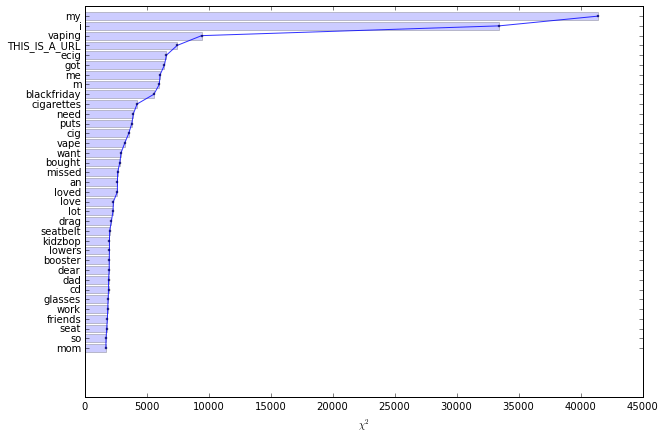

In [159]:
from pylab import barh,plot,yticks,show,grid,xlabel,figure
#specifies the size of the graph
figure(figsize=(10,7))

#makes combination of the chiscore and the name of the feature
wscores = zip(vectorizer.get_feature_names(),chi2score)
#print wscores

#sorts by score of chi-square
wchi2 = sorted(wscores,key=lambda x:x[1]) 
print '\n',wchi2[-35:],'\n'
model
#defines the ploting variables 
topchi2 = zip(*wchi2[-35:]) #gets  the features and scores in a separeted way to plot
x = range(len(topchi2[1])) #lenght of y axis
labels = topchi2[0] #x axis labels

barh(x,topchi2[1],align='center',alpha=.2,color='b') #configures the horizontal bar using the lenght and the value of the score
plot(topchi2[1],x,'-o',markersize=2,alpha=.8,color='b') #plot the graph
yticks(x,labels)#defines y axis with the features' labels
xlabel('$\chi^2$')
show()

In [34]:
#saving the labels in one file
numpy.savetxt("D:\Research\probsDef.txt", prediction, delimiter=",")

#Merging files with labels and tweets

In [84]:
import csv
all1 = []
i=-1

with open('D:\\test.csv','rb') as csvinput:
    with open('D:\\output1.csv', 'wb') as csvoutput:
        with open('D:\\organicDef.csv') as file1:
            writer = csv.writer(csvoutput, lineterminator='\n')
            reader = csv.reader(csvinput)
            reader1 = csv.reader(file1)

            for row in reader1:
                if i==-1:
                    row[38] = 'class'
                elif i >= 0:
                    row[38]=prediction[i]     
                writer.writerow(row) 
                i+=1
                if i > 992632:
                    break
     

In [ ]:
#Reading file with all testing tweets, which were classified

In [94]:
from collections import Counter
import csv
labeled_tweets=[]
pos = 0
neg =0

with open( 'D:\\Research\\testingTweets_Classes.csv', "rb" ) as theFile:
    reader = csv.DictReader( theFile )
    for row in reader:
        labeled_tweets.append(row)
        if row['class'] == '1':
            pos+=1
        else:
            neg+=1
print pos, ' tweets are positive and', neg, 'are negative'

265831  tweets are positive and 726802 are negative


In [92]:
print labeled_tweets[1]['posted_time'],labeled_tweets[1]['text'],labeled_tweets[1]['class']

10/1/2012 00:01:19 nickdrake: C3P0 Enjoys a cigarette break during filming. http://t.co/AVCtEml4 0


#Parse posted time (date), generate graph with tweets by month

In [320]:
# Tweets by month.
def parse_date(datestring):
    """ Input, e.g., 10/1/2012
    Output, e.g., 2012-10"""
    parts = datestring.split()
    if len(parts) > 1:
        datestring = parts[0]
        parts = datestring.split('/')
        if len(parts) == 3:
            s = (parts[2] if len(parts[2]) == 4 else '20' + parts[2]) + \
            '-' + (parts[0] if len(parts[0]) == 2 else '0'+parts[0])
            return datetime.datetime.strptime(s, "%Y-%m").date()
    return None

All tweets [30025, 36995, 46271, 62883, 65971, 90870, 110735, 84692, 96447, 94180, 114894, 158669] .Total:  992632
Positive tweets [8493, 10135, 13116, 17242, 18652, 22375, 28034, 24310, 23276, 26574, 31461, 42163] .Total:  265831
Negative tweets [21532, 26860, 33155, 45641, 47319, 68495, 82701, 60382, 73171, 67606, 83433, 116506] .Total:  726801


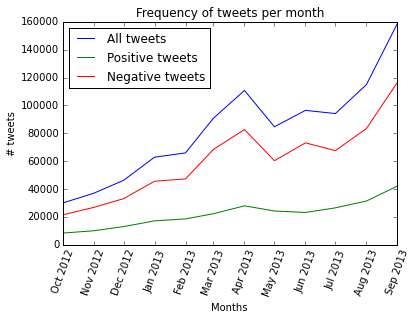

In [382]:
def tweets_by_month(tweets):
    #parsing date for all_tweets, positive and negative
    
    months = Counter(parse_date(x['posted_time']) for x in tweets)#all
    months1 = Counter(parse_date(x1['posted_time']) for x1 in tweets if x1['class']=='1')#positive
    months0 = Counter(parse_date(x0['posted_time']) for x0 in tweets if x0['class']=='0')#negative
    
    result = Counter((k, v) for k, v in months.iteritems() if k is not None)#all
    result1 = Counter((k, v) for k, v in months1.iteritems() if k is not None)#positive
    result0 = Counter((k, v) for k, v in months0.iteritems() if k is not None)#negative
    
    keys = [f for f in sorted(result.keys())if f is not None]#all
    keys1 = [d for d in sorted(result1.keys())if d is not None]#positive
    keys0 = [e for e in sorted(result0.keys())if e is not None]#negative
    
    
    values = [r[1] for r in keys]
    keys = [r[0] for r in keys]
    print 'All tweets', values, '.Total: ',sum(values)

    values1 = [r[1] for r in keys1]
    keys1 = [r[0] for r in keys1]
    print 'Positive tweets', values1, '.Total: ',sum(values1)

    values0 = [r[1] for r in keys0]
    keys0 = [r[0] for r in keys0]
    print 'Negative tweets', values0, '.Total: ',sum(values0)


    plt.figure()
    ax = plt.subplot(111)
    plt.xticks(rotation=70) 
    ax.xaxis_date()
    #plt.plot(keys, values, keys1, values1, keys0, values0)
    line, = plt.plot(keys, values, label="Line ")#, linestyle='dotted')
    line1, = plt.plot(keys1, values1, label="Line 1")#, linestyle='dashed')
    line0, = plt.plot(keys0, values0, label="Line 0")#, linestyle='dashdot')
    plt.xlabel('Months')
    plt.ylabel('# tweets')
    plt.title('Frequency of tweets per month')
    plt.legend([line, line1,line0], ["All tweets", "Positive tweets", "Negative tweets"], loc=0)

    
tweets_by_month(labeled_tweets)

** Considering just one tweet per user**

In [375]:
# Retain tweets from users who have tweeted once.
user_counts = Counter(t['username'] for t in labeled_tweets)
tweets = [t for t in labeled_tweets if user_counts[t['username']] == 1]
print '%d tweets from users who tweeted once' % len(tweets)

418315 tweets from users who tweeted once


All tweets [14964, 15881, 20845, 27189, 27868, 41220, 33154, 33932, 42590, 39556, 51389, 69726] .Total:  418314
Positive tweets [4226, 5102, 6786, 8132, 8908, 10174, 9619, 9909, 8985, 10711, 13402, 17320] .Total:  113274
Negative tweets [10738, 10779, 14059, 19057, 18960, 31046, 23535, 24023, 33605, 28845, 37987, 52406] .Total:  305040


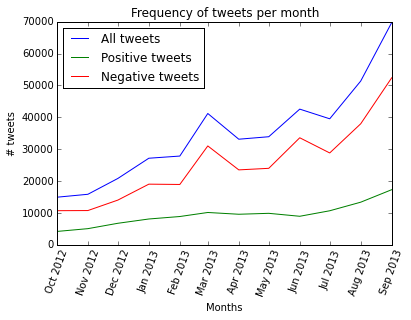

In [377]:
tweets_by_month(tweets)

In [378]:
print '%d users' % len(set(t['username'] for t in tweets))

418315 users


** Eliminating retweets**

In [379]:
# Remove retweets
tweets = [t for t in tweets if t['text'][:2] != 'RT']
print '%d non RT tweets from users who tweeted once' % len(tweets)

293483 non RT tweets from users who tweeted once


All tweets [10974, 12322, 14327, 20676, 21276, 28038, 23588, 24236, 29049, 27650, 34975, 46371] .Total:  293482
Positive tweets [3569, 4223, 5274, 6859, 7125, 8784, 7570, 8127, 7688, 8678, 10357, 12208] .Total:  90462
Negative tweets [7405, 8099, 9053, 13817, 14151, 19254, 16018, 16109, 21361, 18972, 24618, 34163] .Total:  203020


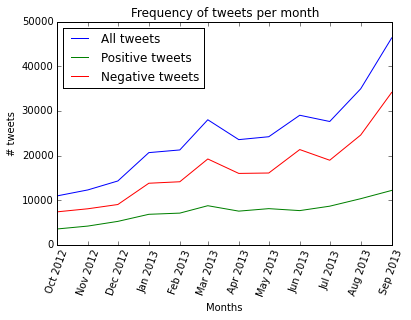

In [380]:
tweets_by_month(tweets)

#Validate on new data 

In [358]:
#Reading 200 tweets which were manually labeled
d=[]
d_200 = []

with open('D:\\Research\\organicTweetsSample200.csv', 'rb') as sample:
    reader1 = csv.DictReader( sample )
    for s in reader1:
        d_200.append(s)
        d.append(s['sent'])
d = np.array([int(t) for t in d])#savind labels of the class in y

In [359]:
#Creating the transform 
from sklearn.feature_extraction.text import TfidfVectorizer
vec_200 = vectorizer.transform(t['text'] for t in d_200)

In [360]:
#predicting
prediction_200 = model_mod.predict(vec_200)

In [363]:
#accuracy according to labels manually put
acc =  1. * len([1 for tr, pr in zip(d, prediction_200) if tr == pr]) / len(d)
print 'Accuracy is ', acc

Accuracy is  0.785
